In [2]:
from google.colab import drive
drive.mount('/content/drive')
!cp -r /content/drive/MyDrive/comp9517/Aerial_Landscapes /content/
data_dir = "/content/Aerial_Landscapes"

Mounted at /content/drive


In [3]:
import os
res_dir = '/content/drive/MyDrive/comp9517/res'
os.makedirs(res_dir, exist_ok=True)

## resnet18

Using device: cuda


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 170MB/s]


Epoch 1/5
Epoch 1/5 - Loss: 123.1796
Epoch 2/5
Epoch 2/5 - Loss: 26.9572
Epoch 3/5
Epoch 3/5 - Loss: 14.2878
Epoch 4/5
Epoch 4/5 - Loss: 9.8925
Epoch 5/5
Epoch 5/5 - Loss: 9.2493

Total training time: 97.16 seconds
Classification Report (ResNet18):
              precision    recall  f1-score   support

 Agriculture     0.9448    1.0000    0.9716       154
     Airport     0.9815    0.9408    0.9607       169
       Beach     0.9932    0.9484    0.9703       155
        City     0.9512    0.9936    0.9720       157
      Desert     0.9207    0.9934    0.9557       152
      Forest     0.9819    0.9645    0.9731       169
   Grassland     0.9543    0.9766    0.9653       171
     Highway     0.9773    0.8958    0.9348       144
        Lake     0.9308    0.9801    0.9548       151
    Mountain     0.9592    0.9276    0.9431       152
     Parking     0.9824    1.0000    0.9911       167
        Port     0.9836    0.9890    0.9863       182
     Railway     0.9259    0.9494    0.9375     

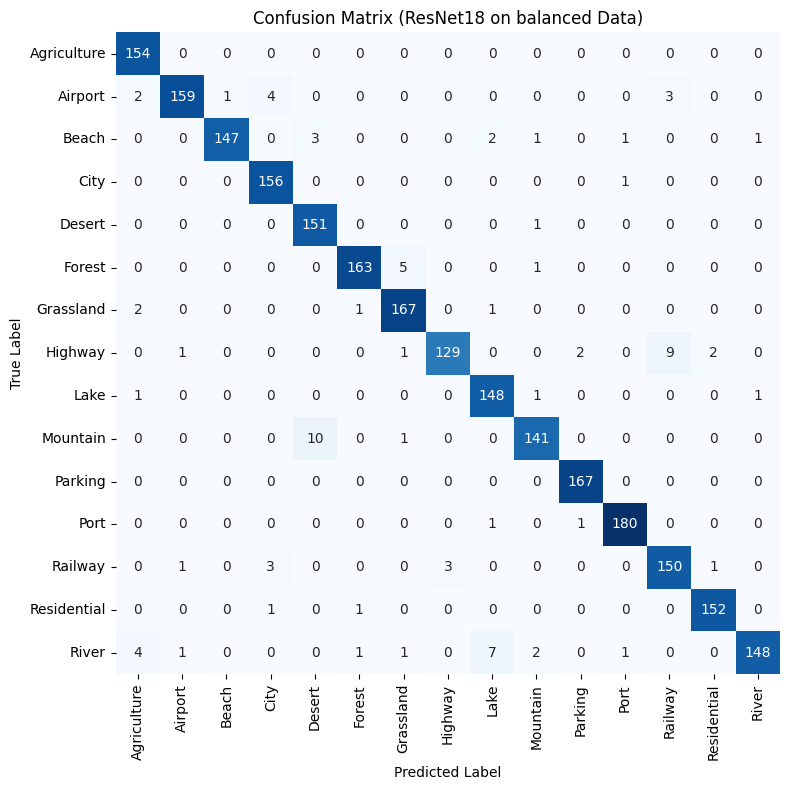

In [4]:
'''resnet18'''
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

weights = ResNet18_Weights.DEFAULT
preprocess = weights.transforms()

dataset = datasets.ImageFolder(root=data_dir, transform=preprocess)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_ds, test_ds = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

model = resnet18(weights=weights)
num_classes = len(dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

start_time = time.time()
for epoch in range(5):
    model.train()
    total_loss = 0
    print(f"Epoch {epoch+1}/5")
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/5 - Loss: {total_loss:.4f}")

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTotal training time: {elapsed_time:.2f} seconds")

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

class_names = dataset.classes
print("Classification Report (ResNet18):")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names, cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (ResNet18 on balanced Data)")
plt.tight_layout()
plt.savefig(f'{res_dir}/resnet18_balanced.png')

## efficientnet_b0

Using device: cuda


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 139MB/s] 


Epoch 1/5 - Loss: 255.8614
Epoch 2/5 - Loss: 51.8362
Epoch 3/5 - Loss: 30.8773
Epoch 4/5 - Loss: 19.6744
Epoch 5/5 - Loss: 13.6470

Total training time: 132.06 seconds
Classification Report (EfficientNet_b0):
              precision    recall  f1-score   support

 Agriculture     1.0000    0.9708    0.9852       171
     Airport     0.9869    0.9869    0.9869       153
       Beach     0.9939    0.9939    0.9939       163
        City     0.9711    0.9882    0.9796       170
      Desert     0.9815    0.9521    0.9666       167
      Forest     1.0000    0.9653    0.9824       173
   Grassland     0.9688    0.9936    0.9810       156
     Highway     0.9770    0.9884    0.9827       172
        Lake     0.9686    0.9809    0.9747       157
    Mountain     0.9452    0.9650    0.9550       143
     Parking     0.9929    0.9858    0.9893       141
        Port     0.9934    0.9868    0.9901       152
     Railway     0.9793    0.9726    0.9759       146
 Residential     0.9704    0.9820 

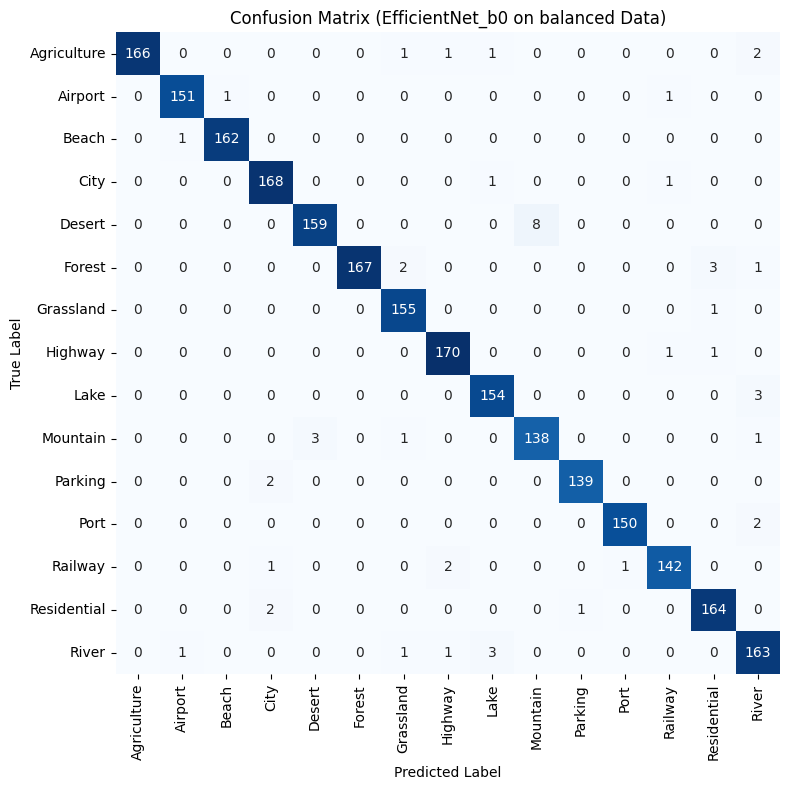

In [5]:
'''effientnet'''
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

weights = EfficientNet_B0_Weights.DEFAULT
preprocess = weights.transforms()

dataset = datasets.ImageFolder(root=data_dir, transform=preprocess)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_ds, test_ds = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

model = efficientnet_b0(weights=weights)
num_classes = len(dataset.classes)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

start_time = time.time()

for epoch in range(5):
    model.train()
    total_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/5 - Loss: {total_loss:.4f}")

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTotal training time: {elapsed_time:.2f} seconds")

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

class_names = dataset.classes
print("Classification Report (EfficientNet_b0):")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names, cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (EfficientNet_b0 on balanced Data)")
plt.tight_layout()
plt.savefig(f'{res_dir}/efficientNet_b0_balanced.png')